In [121]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

In [122]:
np.random.seed(13)
rng = np.random

In [123]:
# --------------------
# Config
# --------------------
n_users = 300
n_artists = 30
n_tracks_avg = 16
start_date = datetime(2025, 1, 1)
end_date = datetime(2025, 3, 31)
artist_weighting = 0.5
track_weighting = 0.7
weekend_effect=1.05
#short_session_prob=0.15
#short_session_choices=(1,2,3)
#lognorm_mu=1.0           
#lognorm_sigma=0.9
avg_inter_track_sec=210
std_inter_track_sec=45

In [124]:
# --------------------
# Artist + Track metadata
# --------------------
artist_ids = [f"artist_{i+1}" for i in range(n_artists)]
tracks = []

ranks = np.arange(1, n_artists + 1)
artist_weights = 1 / ranks ** artist_weighting
artist_weights = artist_weights / artist_weights.sum()

for a_idx, aid in enumerate(artist_ids):
    n_tracks = np.random.randint(1/2*n_tracks_avg, 2*n_tracks_avg)
    ranks = np.arange(1, n_tracks + 1)
    weighting = rng.uniform(0,track_weighting)
    track_weights = 1 / ranks ** weighting
    track_weights = track_weights / track_weights.sum()
    for t in range(n_tracks):
        t_len = np.random.normal(loc=avg_inter_track_sec, 
                                 scale=std_inter_track_sec)
        tracks.append({
            "artist_id": aid, 
            "track_id": f"{aid}_track_{t+1}", 
            "track_len_sec":t_len,
            "artist_popularity": artist_weights[a_idx],
            "track_popularity": track_weights[t],
            "total_track_popularity": artist_weights[a_idx] * track_weights[t]
                      })
tracks_df = pd.DataFrame(tracks)



In [125]:
tracks_df.head()

,artist_id,track_id,track_len_sec,artist_popularity,track_popularity,total_track_popularity
0,artist_1,artist_1_track_1,234.836382,0.104328,0.097664,0.010189
1,artist_1,artist_1_track_2,179.183451,0.104328,0.072737,0.007589
2,artist_1,artist_1_track_3,237.418483,0.104328,0.061220,0.006387
3,artist_1,artist_1_track_4,274.281367,0.104328,0.054172,0.005652
4,artist_1,artist_1_track_5,188.201603,0.104328,0.049269,0.005140


In [126]:
# --------------------
# User metadata
# --------------------
mixed_sesh_pct = 0.5 # are they less mixed < 0.5 = single artists
popular_music_fan = 0.5 # are they more into popular artists > 0.5 or even mix
songs_per_sesh_mu = 6
sesh_per_day_mu = 2
mixed_sesh_time = 0.5 # are they a random sesh < 0.5 or ordered sesh i.e. morning
skip_prob = 0.2 # lower means less chance of skipping songs

users = []
for user_id in range(1, n_users + 1):
    users.append(
        {"user_id": user_id,
        "mix_sesh": rng.uniform(),
        "pop_fan": rng.uniform(),
        "sesh_len": np.clip(rng.poisson(songs_per_sesh_mu), 1, 10000),
        "sesh_num": np.clip(rng.poisson(sesh_per_day_mu), 1, 10000),
        "skip_prob": np.clip(rng.normal(0.4,.25),0.05,0.9)}
    )
users_df = pd.DataFrame(users)

In [127]:
users_df.head()

,user_id,mix_sesh,pop_fan,sesh_len,sesh_num,skip_prob
0,1,0.770236,0.449934,7,1,0.722269
1,2,0.678292,0.198552,7,2,0.449958
2,3,0.631687,0.335670,2,1,0.155921
3,4,0.583200,0.587551,8,2,0.538524
4,5,0.622390,0.508089,5,1,0.514179


In [140]:
# --------------------
# Stream Generation
# --------------------
date_range = pd.date_range(start_date, end_date, freq="D")
streams = []

currrent_sesh = 0
for user_id in users_df['user_id']:

    temp_user_df = users_df[users_df['user_id'] == user_id].iloc[0]

    for day in date_range:
        
        day_factor = weekend_effect if day.weekday() >= 5 else 1.0
        n_sessions = rng.poisson(temp_user_df['sesh_num'] * day_factor)

        if n_sessions == 0:
            continue

        for sesh_i in range(n_sessions):
            n_streams = np.clip(rng.poisson(temp_user_df['sesh_len'] * day_factor), 1, 10000)

            session_start = pd.Timestamp(
                year=day.year, month=day.month, day=day.day,
                hour=rng.randint(0, 24),
                minute=rng.randint(0, 60),
                second = rng.randint(0, 60)
            )

            ts = session_start

            if rng.random() < temp_user_df['mix_sesh']:
                # Mixed session: all tracks are weighted by track popularity
                session_tracks = tracks_df.sample(
                    n=n_streams,
                    replace=True,
                    weights=tracks_df['total_track_popularity']
                )
            else:
                # Focused session: pick one artist, then sample from their tracks
                artist_choice = tracks_df['artist_id'].sample(
                    n=1,
                    weights=tracks_df['artist_popularity']
                ).iloc[0]
                
                session_tracks = tracks_df.query(
                    "artist_id == @artist_choice"
                ).sample(
                    n=n_streams,
                    replace=True
                )

            for _, track in session_tracks.iterrows():
                
                track_len = track['track_len_sec']
                if np.random.rand() < temp_user_df['skip_prob']:
                    skip_fraction = np.random.uniform(0.01, 0.9)  
                    listen_time = track_len * skip_fraction
                else:
                    listen_time = track_len

                streams.append({
                    "user_id": user_id,
                    "session_id": currrent_sesh,
                    "timestamp": ts,
                    "artist_id": track['artist_id'],
                    "track_id": track['track_id'],
                    "track_duration_sec": track_len,
                    "listen_duration_sec": listen_time,
                    "is_bot": False
                })

                ts += pd.Timedelta(seconds=listen_time)
            currrent_sesh+=1

In [141]:
streams_df = pd.DataFrame(streams)

In [142]:
streams_df.sort_values(['timestamp'])

,user_id,session_id,timestamp,artist_id,track_id,track_duration_sec,listen_duration_sec,is_bot
260894,221,41446,2025-01-01 00:00:41.000000000,artist_28,artist_28_track_11,188.173868,102.250218,False
322844,277,51148,2025-01-01 00:00:49.000000000,artist_10,artist_10_track_22,225.759591,43.252787,False
128023,115,20353,2025-01-01 00:00:52.000000000,artist_3,artist_3_track_12,225.623916,225.623916,False
322845,277,51148,2025-01-01 00:01:32.252787283,artist_7,artist_7_track_11,181.776026,131.495470,False
260895,221,41446,2025-01-01 00:02:23.250217796,artist_1,artist_1_track_11,194.036741,26.509445,False
...,...,...,...,...,...,...,...,...
111053,101,17461,2025-04-01 00:31:43.259406550,artist_3,artist_3_track_10,211.948474,99.238288,False
111054,101,17461,2025-04-01 00:33:22.497694881,artist_3,artist_3_track_11,189.751056,158.885184,False
111055,101,17461,2025-04-01 00:36:01.382879009,artist_3,artist_3_track_4,199.654601,199.654601,False
111056,101,17461,2025-04-01 00:39:21.037479743,artist_3,artist_3_track_6,206.271199,116.685547,False


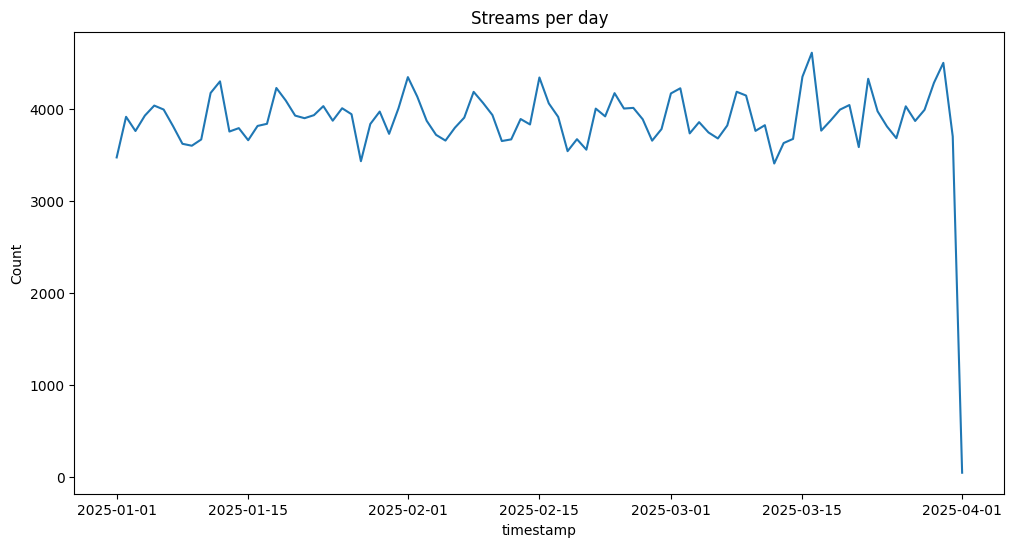

In [147]:
vc = (streams_df)['timestamp'].dt.date.value_counts()
vc = vc.sort_index()
vc.plot(kind='line', figsize=(12, 6))

plt.ylabel('Count')
plt.title('Streams per day')
plt.show()

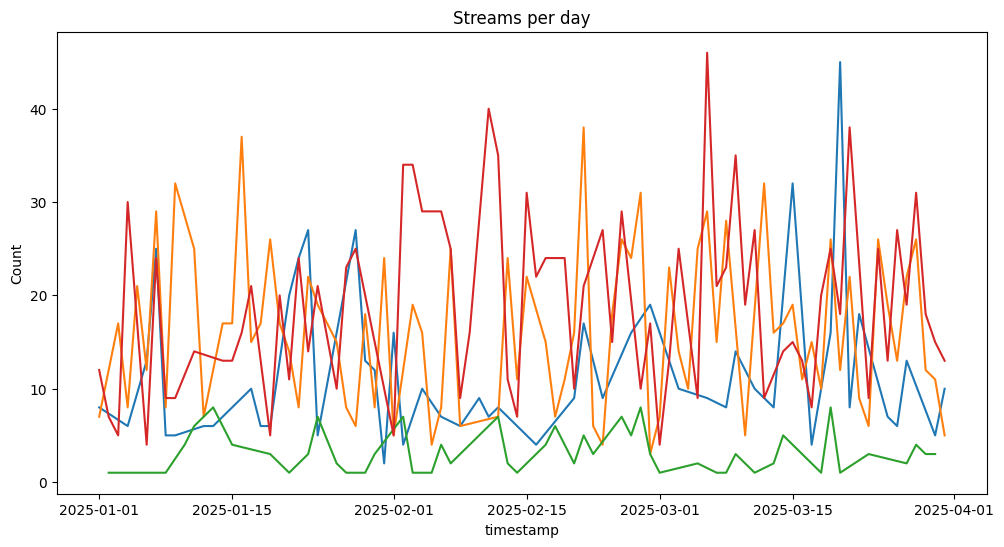

In [148]:
vc = (streams_df[streams_df['user_id']==1])['timestamp'].dt.date.value_counts()
vc = vc.sort_index()
vc.plot(kind='line', figsize=(12, 6))

vc = (streams_df[streams_df['user_id']==2])['timestamp'].dt.date.value_counts()
vc = vc.sort_index()
vc.plot(kind='line', figsize=(12, 6))

vc = (streams_df[streams_df['user_id']==3])['timestamp'].dt.date.value_counts()
vc = vc.sort_index()
vc.plot(kind='line', figsize=(12, 6))

vc = (streams_df[streams_df['user_id']==4])['timestamp'].dt.date.value_counts()
vc = vc.sort_index()
vc.plot(kind='line', figsize=(12, 6))

plt.ylabel('Count')
plt.title('Streams per day')
plt.show()

In [149]:
def inject_long_session_bot(streams_df, start_time, duration_hours=5, artist_id=None):

    bot_user_id = streams_df['user_id'].max() + 1
    max_sess = streams_df['session_id'].max() if 'session_id' in streams_df.columns else 0
    new_session_id = max_sess + 1

    if artist_id is None:
        artist_id = streams_df['artist_id'].sample(1).iloc[0]
    track_length_sec = avg_inter_track_sec

    n_streams = int(duration_hours * 3600 / track_length_sec)
    timestamps = [start_time + pd.Timedelta(seconds=i*track_length_sec) for i in range(n_streams)]

    tracks_sampled = tracks_df[tracks_df['artist_id'] == artist_id].sample( \
            n=n_streams, replace=True)

    bot_streams = pd.DataFrame({
        'user_id': [bot_user_id] * n_streams,
        'session_id': [new_session_id] * n_streams,
        'timestamp': timestamps,
        'artist_id': [artist_id] * n_streams,
        'track_id': tracks_sampled['track_id'],
        'track_duraton_sec': tracks_sampled['track_len_sec'],
        'listen_duration_sec':  tracks_sampled['track_len_sec'],
        'is_bot': True
    })

    return pd.concat([streams_df, bot_streams], ignore_index=True)

In [164]:
def inject_bot_sessions(streams_df, n_sessions, bot_fn, start_time, duration_hours, wait_hours, artist_id=None):
    
    timestamps = [start_time + pd.Timedelta(hours=i*duration_hours) + \
                  pd.Timedelta(hours=i*wait_hours) for i in range(n_sessions)]
    temp_df = streams_df
    for timestamp in timestamps:
        temp_df = bot_fn(temp_df, timestamp, duration_hours, artist_id)

    return temp_df

In [167]:
bot_streams_df = inject_bot_sessions(streams_df, 100, inject_long_session_bot, 
            pd.Timestamp(year=2025, month=1, day=11, hour=15, minute=30, second=0),
            duration_hours=5,
            wait_hours=12)

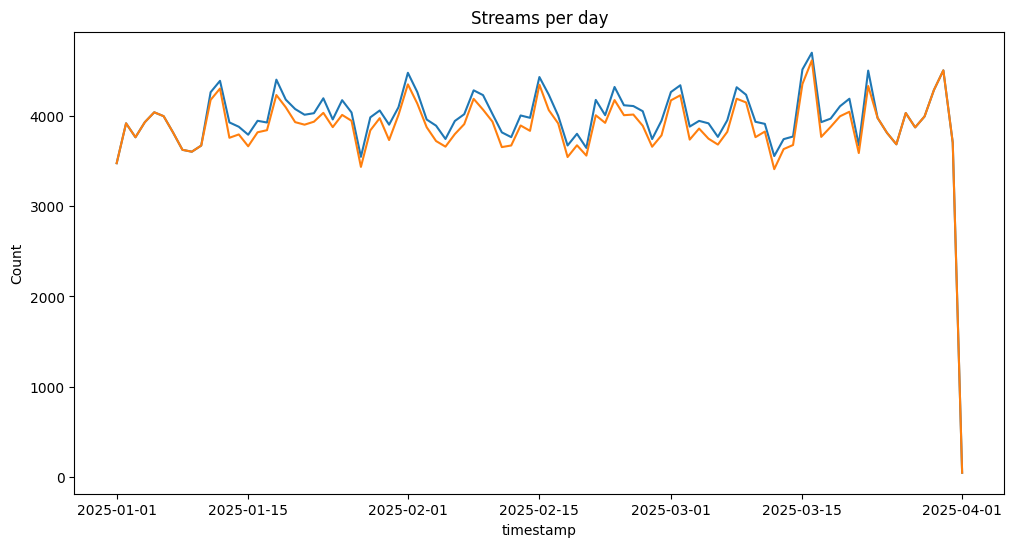

In [168]:
vc = (bot_streams_df)['timestamp'].dt.date.value_counts()
vc = vc.sort_index()
vc.plot(kind='line', figsize=(12, 6))

vc = (streams_df)['timestamp'].dt.date.value_counts()
vc = vc.sort_index()
vc.plot(kind='line', figsize=(12, 6))

plt.ylabel('Count')
plt.title('Streams per day')
plt.show()